<a href="https://colab.research.google.com/github/csarge/github-slideshow/blob/main/horse_autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-lightning
!pip install pytorch-msssim

In [ ]:
import os
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt


import torch 
import torchvision
import torch.nn as nn
import torchvision.transforms as transforms
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader, random_split
from torchvision.utils import save_image

import pytorch_lightning as pl
from pytorch_lightning import Trainer
from pytorch_msssim import ssim, ms_ssim, SSIM, MS_SSIM 
from torch.utils.tensorboard import SummaryWriter

In [ ]:
write = SummaryWriter()

In [ ]:
class HorsesDataModule(pl.LightningDataModule):
  def __init__(self, data_dir='/content/drive/MyDrive/horse2zebra', batch_size=32):
          
          super().__init__()
          
          self.data_dir = data_dir
          self.batch_size = batch_size

          self.dimensions = (1, 256, 256) #dimensions of horse images
          self.transform = transforms.Compose([#[transforms.Grayscale(num_output_channels=1),
               transforms.ToTensor() 
              #transforms.Normalize([0.5], [0.5]) 
          ])
           
  def setup(self, stage=None):
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    # Assign train/val datasets for use in dataloaders        
    all_horses = datasets.ImageFolder('/content/drive/MyDrive/horse2zebra/trainA/', transform=self.transform)
    self.train_horses, self.val_horses = random_split(all_horses, [950, 117])
      # Assign test dataset for use in dataloader(s)
    test_horses = datasets.ImageFolder('/content/drive/MyDrive/horse2zebra/testA/', transform=self.transform)
    self.test_horses = test_horses
 
  def train_dataloader(self):
    train_loader = DataLoader(self.train_horses, batch_size=self.batch_size)
    return train_loader
    
  def val_dataloader(self):
    val_loader = DataLoader(self.val_horses, batch_size=self.batch_size)
    return val_loader
    
  def test_dataloader(self):
    test_loader = DataLoader(self.test_horses, batch_size=self.batch_size)
    return test_loader



In [ ]:
class MS_SSIM_Loss(MS_SSIM):
    def forward(self, img1, img2):
        return  1 - super(MS_SSIM_Loss, self).forward(img1, img2) #some examples multiply by 100, unsure why??


class SSIM_Loss(SSIM):
    def forward(self, img1, img2):
        return  1 - super(SSIM_Loss, self).forward(img1, img2)

#call criterion in later 
criterion = MS_SSIM_Loss(data_range=1.0, size_average=True, channel=3).cuda() 

#loss is ~0.02 with MS_SSIM loss. 
# 1 -super() used to maximise the loss (higher value = better)

In [ ]:
class convAutoencoder(pl.LightningModule):
  
  def __init__(self):
    super().__init__()

    #Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(in_channels = 3, out_channels = 8, kernel_size = 4, 
                  stride = 2, padding = 1, 
                  dilation = 1, groups = 1, 
                  bias = True, padding_mode = 'zeros'),
        nn.ReLU(),
        nn.Conv2d(in_channels = 8, out_channels = 16, kernel_size = 4, 
                  stride = 2, padding = 1, 
                  dilation = 1, groups = 1, 
                  bias = True, padding_mode = 'zeros'),
        nn.ReLU(),
        
    )
    #Decoder
    self.decoder = nn.Sequential(
        nn.Upsample(scale_factor=4, mode='bilinear'),
        nn.Conv2d(in_channels = 16, out_channels = 8, kernel_size = 4, 
                  stride = 2, padding = 1, 
                  dilation = 1,  groups = 1, 
                  bias = True, padding_mode = 'zeros'),
        nn.ReLU(),
        nn.Upsample(scale_factor=4, mode='bilinear'),
        nn.Conv2d(in_channels = 8, out_channels = 3, kernel_size = 4, 
                  stride = 2, padding = 1, 
                  dilation = 1, groups = 1, 
                  bias = True, padding_mode = 'zeros'),
        nn.ReLU(),

    )
  def forward(self,x):
    # defines an inference action
    embedding = self.decoder(self.encoder(x))
    return embedding
  
  def training_step(self, batch, batch_idx):
    # training_step defined the train loop.
    # It is independent of forward
    x, y = batch
    #x = x.view(x.size(0), -1)
    z = self.encoder(x)
    reconstructed_img = self.decoder(z)
    #calculate loss
    training_loss = criterion(reconstructed_img, x)
    #training_loss = F.mse_loss(reconstructed_img, x)
    self.log('train_loss', training_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
    return training_loss

  def validation_step(self, batch, batch_idx):
    x, y = batch
    z = self.encoder(x)
    reconstructed_img = self.decoder(z)
    validation_loss = criterion(reconstructed_img, x)
    #validation_loss = F.mse_loss(reconstructed_img, x)
    self.log('val_loss', validation_loss, prog_bar = True)
    return validation_loss

  def test_step(self, batch, batch_idx):
    x, y = batch
    z = self.encoder(x)
    reconstructed_img = self.decoder(z)
    testing_loss = criterion(reconstructed_img, x)
    #testing_loss = F.mse_loss(reconstructed_img, x)
    self.log('testing_loss', testing_loss, prog_bar = True)
    return testing_loss

  def configure_optimizers(self):
    optimizer = optim.Adam(self.parameters(), lr=1e-3)
    return optimizer

Logging to Tensorboard by default:
* on_step (logs the metric at that step in training)
* on_epoch (automatically accumulates and logs at the end of the epoch)
* prog_bar (logs to the progress bar)
* logger (logs to the logger like Tensorboard)

In [ ]:
if __name__ == '__main__':
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

  #Data:
  horse_data = HorsesDataModule()

  #Model:
  model = convAutoencoder()
  print(model)
  #Trainer:
  trainer = Trainer(max_epochs=200,gpus=1, progress_bar_refresh_rate=1)
  trainer.fit(model, horse_data)


  # test
  trainer.validate(val_dataloaders=horse_data.val_dataloader)
  trainer.test(datamodule=horse_data)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


convAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(3, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(8, 16, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (3): ReLU()
  )
  (decoder): Sequential(
    (0): Upsample(scale_factor=4.0, mode=bilinear)
    (1): Conv2d(16, 8, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (2): ReLU()
    (3): Upsample(scale_factor=4.0, mode=bilinear)
    (4): Conv2d(8, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (5): ReLU()
  )
)
Mounted at /content/drive


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | encoder | Sequential | 2.5 K 
1 | decoder | Sequential | 2.4 K 
---------------------------------------
4.9 K     Trainable params
0         Non-trainable params
4.9 K     Total params
0.020     Total estimated model params size (MB)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mounted at /content/drive


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_loss': 0.027888217940926552}
--------------------------------------------------------------------------------


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Mounted at /content/drive



--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'testing_loss': 0.02448645792901516, 'val_loss': 0.027888217940926552}
--------------------------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


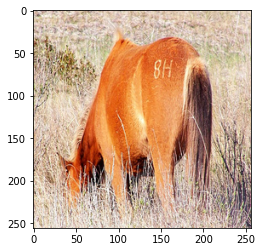

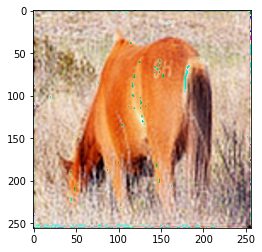

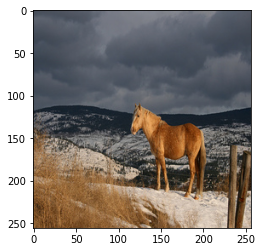

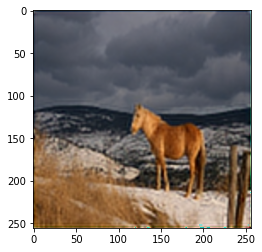

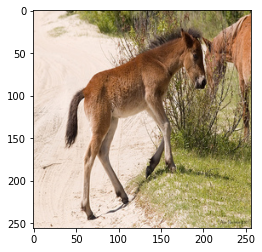

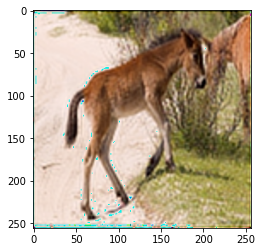

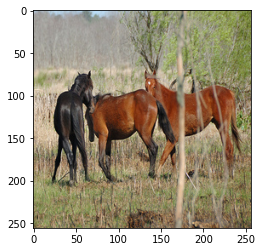

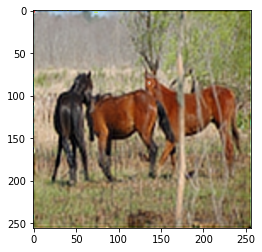

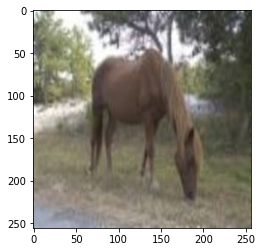

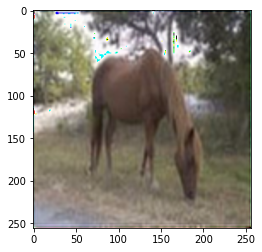

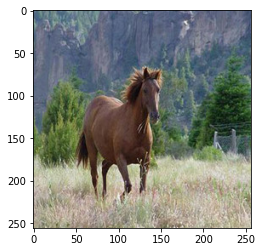

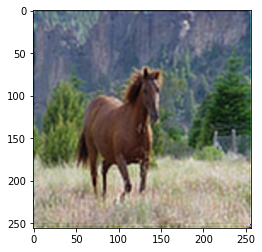

In [ ]:
get_ipython().magic('matplotlib inline')

trans = transforms.ToPILImage() 


model.eval()
with torch.no_grad():
  for batch in horse_data.val_dataloader():
      original_imgs = batch[0]
      outputs = model(original_imgs)
      for i in range(len(outputs)):
          plt.figure()
          plt.imshow(trans(original_imgs[i]))
          plt.figure()
          plt.imshow(trans(outputs[i]))
          if i==5:
              break
      break




/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3458: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


AttributeError: ignored

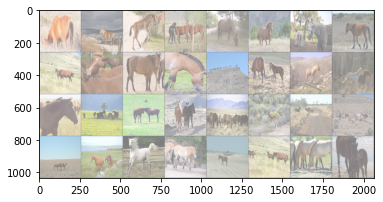

In [ ]:
get_ipython().magic('load_ext tensorboard')
get_ipython().magic('tensorboard --logdir ./lightning_logs/ --port=6000')

